# **Assignment #2**
## **Introduction**
#### This document was developed by Mr. Emanuel Y. Gloria and Ms. Viel Celis as one of the academic requirement/assignment for the CMSC 210: Artificial Intelligence course for the Diploma in Computer Science degree.

#### *Please note that the data used in this assignment was acquired via survey by the aforementioned students. Also, the code below was written to run each of the algorithms independently and was not simplified for purposes of showing all the steps in the model development process.*

##**Data Pre-processing**

###### **Load and Check Data**

In [ ]:
# Warning: The data was imported from my Google Drive and this might not work
# for others who does not have my UP Mail credentials. Suggest to run the scripts
# on your local machine and create a working directory with the CSV file in it.

# Import the libraries to load the survey data from Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')

# Set the search parameters
filename = 'Gloria-Celis_Use of Telehealth and Digital Health Tools.csv'
search_path = '/content/drive/My Drive/Diploma in Computer Science - UPOU Documents/Colab Notebooks/Data'

# Search for the file
for root, dirs, files in os.walk(search_path):
    if filename in files:
        file_path = os.path.join(root, filename)
        break

# Relevant libraries for the analyses
import pandas as pd
import numpy as np
from numpy.random.mtrand import standard_exponential

from sklearn.model_selection import train_test_split, GridSearchCV # Train and Test split and Parameter Tuning
from sklearn.tree import DecisionTreeClassifier, plot_tree         # Decision Tree Classifier
from sklearn.neighbors import KNeighborsClassifier                 # KNN Classifier
from sklearn.naive_bayes import GaussianNB                         # Naive Bayes Classifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report          # Model results
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, ShuffleSplit  # Cross validation
from sklearn.preprocessing import StandardScaler, LabelEncoder

import matplotlib.pyplot as plt                                    # Visualization
from matplotlib.colors import ListedColormap
import seaborn as sns
import math

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path) # Feel free to add the local file path here if you can't access the file via GDrive.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###### **Data Cleaning**

In [ ]:
# Step 1: Remove the following columns: Timestamp, Email Address, Name (Optional)
df = df.iloc[:,3:]

# Step 2: Rename column names
df.columns = ["age","sex","residence","occupation","q1","q2","q3","q4","q5","q6","q7",
 "q8","q9","q10","q11","q12","q13","q14","q15","q16","q17"]

#Step 3: Replace mislabeled and misspelled data entries
df["q5"].replace({'Not Applicable. (If you answered "No" in Q4.)':"Not applicable"}, inplace = True)
df["q12"].replace({"Note concerned":"Not concerned"}, inplace = True)

#Step 4: Convert nominal data from columns age, Q1, and Q11-14 to categorical
# and remap category orders
df["age"] = df["age"].astype("category")
df["age"] = df["age"].cat.reorder_categories(["18-25", "26-30", "31-35","36-40","41- above"])

df["q1"] = df["q1"].astype("category")
df["q1"] = df["q1"].cat.reorder_categories(["Low", "Moderate", "High"])

df["q11"] = df["q11"].astype("category")
df["q11"] = df["q11"].cat.reorder_categories(["Not applicable","Poor", "Fair", "Good", "Excellent"])

df["q12"] = df["q12"].astype("category")
df["q12"] = df["q12"].cat.reorder_categories(["Not concerned", "Somewhat concerned", "Concerned","Very concerned"])

df["q13"] = df["q13"].astype("category")
df["q13"] = df["q13"].cat.reorder_categories(["Not Applicable","None", "Minor", "Moderate", "Significant"])

df["q14"] = df["q14"].astype("category")
df["q14"] = df["q14"].cat.reorder_categories(["Limited", "Adequate", "Good", "Excellent"])

#Step 5: Remove anomalies in the numeric variables
# Remove the two outliers in q8 - respondents using their health apps. 20 and 24 on avg. a day
df["q8"].replace({20: np.nan,24: np.nan}, inplace = True)

#Step 6: Remove rows with NA
df = df.dropna()

In [ ]:
df.head()

,age,sex,residence,occupation,q1,q2,q3,q4,q5,q6,...,q8,q9,q10,q11,q12,q13,q14,q15,q16,q17
0,18-25,Female,Las Pinas,Others,Moderate,KonsultaMd,None,Yes,Moderate,No,...,0.0,3,80,Good,Somewhat concerned,Significant,Good,Avoiding In-Person Visit,Lack of internet,Mobile Phones
1,26-30,Female,Mandaluyong,Information and Communication Technology Profe...,Low,None of the above,None,Yes,Moderate,No,...,0.0,3,60,Good,Concerned,Not Applicable,Adequate,"Consolation Convenience, Time Saving","Privacy concerns, Limited awareness","Mobile Phones, Video Consultation, Wearable De..."
2,26-30,Male,Manila,Information and Communication Technology Profe...,High,None of the above,Maxicare,No,Not applicable,No,...,1.0,3,50,Good,Not concerned,Significant,Good,"Time Saving, Avoiding In-Person Visit",Limited awareness,Mobile Phones
3,26-30,Female,Taguig,Others,Moderate,None of the above,NowServing,Yes,Moderate,Yes,...,1.0,4,70,Good,Somewhat concerned,Moderate,Adequate,"Consolation Convenience, Time Saving",Limited awareness,"Mobile Phones, Wearable Devices"
4,41- above,Male,Pasig,Health Professionals,Low,None of the above,None,No,Not applicable,Yes,...,1.0,3,100,Poor,Very concerned,Minor,Good,"Time Saving, Avoiding In-Person Visit","Lack of internet, Limited awareness",Mobile Phones


## **Data Modeling**

### **Decision Tree Classifier**
* (q1) Target Attribute: Level of Digital Health Adoption (Low, Moderate, and High)
* Other Attributes: (age) Age Range, (q9) Trust in Telehealth (scale 1-5), (q10) Digital Health Literacy Score (score 0-100), (q13) Self-Reported Health Improvement due to Digital Health (None, Minor, Moderate, Significant),and (q14) Accessibility of Telehealth Services (Limited, Adequate, Good, Excellent)

###### **Default Decision Tree Classifier**

In [ ]:
# Separate features and target variable
DT_x = pd.get_dummies(df[["age","q9","q10","q13","q14"]],drop_first=True) # Apply one-hot encoding for the categorical column
DT_y = df['q1']

# Split the dataset into a training set and a testing set
x_train_DT, x_test_DT, y_train_DT, y_test_DT = train_test_split(DT_x, DT_y, train_size= 0.7, test_size=0.3, random_state=42)

# Initialize the Decision Tree Classifier
DT_clf = DecisionTreeClassifier()

# Fit the classifier to the training data
DT_clf.fit(x_train_DT, y_train_DT)

# Make predictions on the test data
y_pred_DT = DT_clf.predict(x_test_DT)

# Calculate the accuracy of the classifier
DT_accuracy = accuracy_score(y_test_DT, y_pred_DT)
print(f"Accuracy on training set: {DT_clf.score(x_train_DT, y_train_DT) * 100:.2f}%")
print(f"Accuracy on test set: {DT_accuracy * 100:.2f}%")

Accuracy on training set: 100.00%
Accuracy on test set: 35.29%


In [ ]:
DT_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

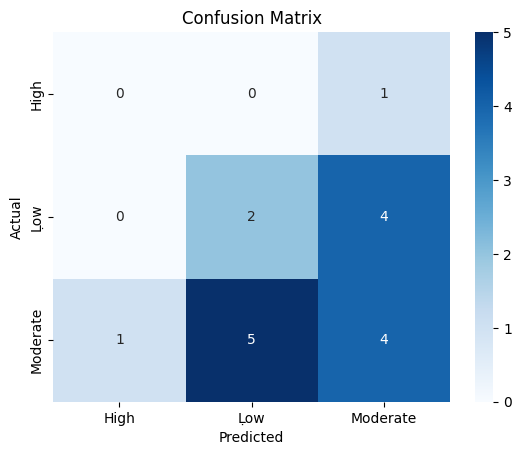


Classification Report:
               precision    recall  f1-score   support

        High     0.0000    0.0000    0.0000         1
         Low     0.2857    0.3333    0.3077         6
    Moderate     0.4444    0.4000    0.4211        10

    accuracy                         0.3529        17
   macro avg     0.2434    0.2444    0.2429        17
weighted avg     0.3623    0.3529    0.3563        17



In [ ]:
# Display the confusion matrix
DT_conf_matrix = confusion_matrix(y_test_DT, y_pred_DT)
sns.heatmap(DT_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["High", "Ḷow","Moderate"], yticklabels=["High", "Ḷow","Moderate"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report with precision, recall, and F1-score
DT_report = classification_report(y_test_DT, y_pred_DT, digits = 4)
print("\nClassification Report:\n", DT_report)

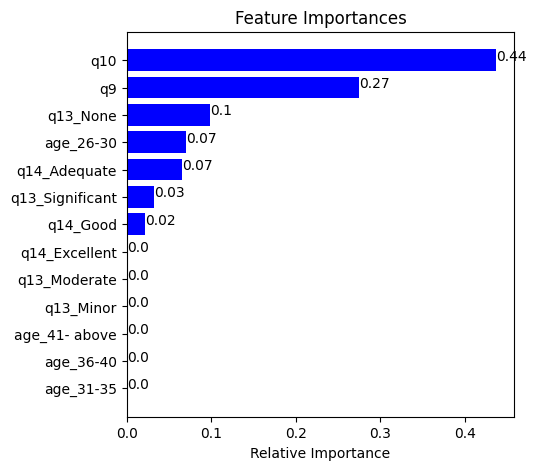

In [ ]:
# Understanding Feature Importance
importance = DT_clf.feature_importances_
index = np.argsort(importance)

plt. figure(figsize=(5, 5))
plt.title('Feature Importances')
plt.barh(range(len(index)), importance[index], color='b', align='center')
plt.yticks(range(len(index)), [x_test_DT.columns[i] for i in index])
plt.xlabel('Relative Importance')

for i in range(len(importance)):
  plt.text(importance[index[i]],i,round(importance[index[i]],2))

plt.show()

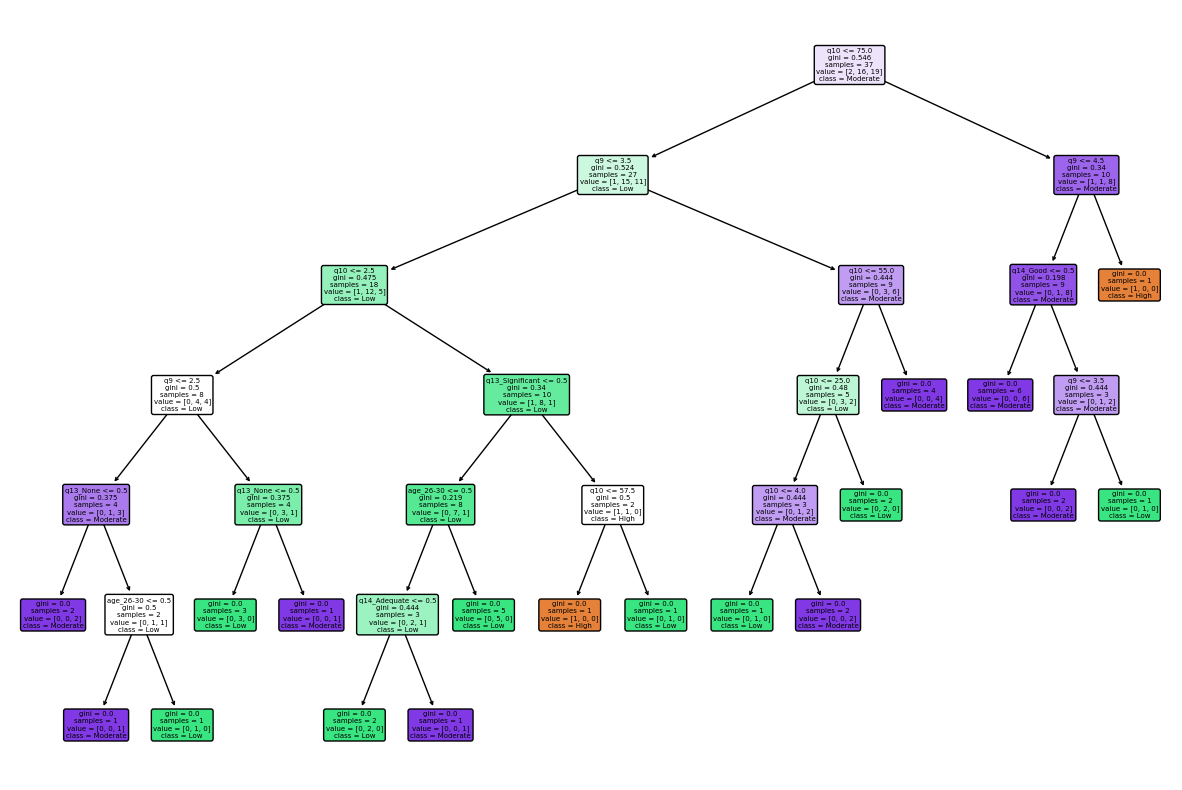

In [ ]:
# Plot and display the decision tree diagram
plt.figure(figsize=(15, 10))
plot_tree(DT_clf, feature_names=DT_x.columns, class_names=DT_clf.classes_, filled=True, rounded=True)
plt.show()

###### **Hyper Parameterized Decision Tree Classifier**

Why apply pruning? It is a method applied to decision trees to avoid overfitting at the same time improves overall performance.

Note: Aside from prunning, other variables were also considered to get the best model.

Parameters
* max_samples_split
> This hyperparameter sets the minimum number of samples required to split an internal node. If a node has fewer samples than min_samples_split, it won't be split further, and it becomes a leaf node. Setting a higher min_samples_split can lead to simpler trees with fewer splits and can help prevent overfitting.
* min_samples_leaf
> Restrict the size of sample leaf.
> This hyperparameter defines the minimum number of samples required to be in a leaf node. If a leaf node has fewer samples than min_samples_leaf, it may get combined with neighboring nodes or pruned. A larger min_samples_leaf can lead to simpler trees and also helps prevent overfitting.
* max_depth
> Reduce the depth of the tree to build a generalized tree
> The depth of a tree corresponds to the number of levels from the root node to the farthest leaf. A smaller max_depth value will result in a shallower tree, while a larger value will result in a deeper tree. Setting max_depth to a finite number can help prevent overfitting, as it limits the complexity of the tree.


In [ ]:
# Define hyperparameters for tuning
## Parameters are based on the results of Default Decision Tree Classifier
DT_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_split': [2, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
}

# Create a GridSearchCV object for hyperparameter tuning
DT_grid_search = GridSearchCV(DT_clf, DT_param_grid, cv=5)

# Fit the model to the training data
DT_grid_search.fit(x_train_DT, y_train_DT)

# Make predictions on the test data
y_pred_best_DT = DT_grid_search.predict(x_test_DT)

# Get the best hyperparameters
DT_best_params = DT_grid_search.best_params_

# Train a decision tree with the best hyperparameters
best_dt_classifier = DecisionTreeClassifier(**DT_best_params)
best_dt_classifier.fit(x_train_DT, y_train_DT)

# Evaluate the model on the test data
accuracy_bestDT = best_dt_classifier.score(x_test_DT, y_test_DT)
print(f"Accuracy on training set: {best_dt_classifier.score(x_train_DT, y_train_DT) * 100:.2f}%")
print(f"Accuracy on test set: {accuracy_bestDT* 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Accuracy on training set: 94.59%
Accuracy on test set: 47.06%


In [ ]:
#Show best parameters
DT_best_params

{'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
# Access the results
results = DT_grid_search.cv_results_

# Print all the results
i = 0
for mean_score, params in zip(results["mean_test_score"], results["params"]):
    i = i + 1
    print(f"{i}. Mean Test Score: {mean_score:.4f}, Hyperparameters: {params}")

1. Mean Test Score: 0.5179, Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
2. Mean Test Score: 0.4643, Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4}
3. Mean Test Score: 0.5679, Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
4. Mean Test Score: 0.5679, Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
5. Mean Test Score: 0.5643, Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 4}
6. Mean Test Score: 0.5929, Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
7. Mean Test Score: 0.5714, Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2}
8. Mean Test Score: 0.5714, Hyperparameters: {'criterion': 'gini', 'm

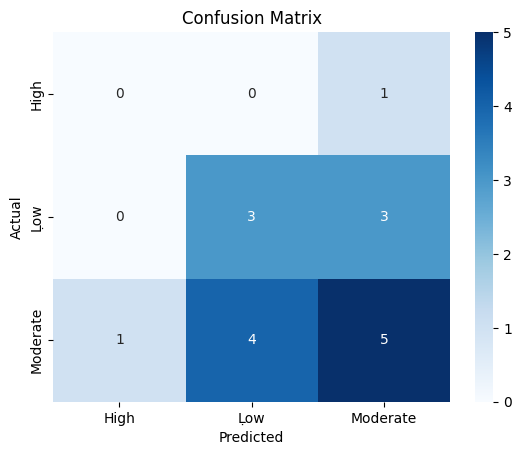


Classification Report:
               precision    recall  f1-score   support

        High     0.0000    0.0000    0.0000         1
         Low     0.4286    0.5000    0.4615         6
    Moderate     0.5556    0.5000    0.5263        10

    accuracy                         0.4706        17
   macro avg     0.3280    0.3333    0.3293        17
weighted avg     0.4781    0.4706    0.4725        17



In [ ]:
# Display the confusion matrix
bestDT_conf_matrix = confusion_matrix(y_test_DT, y_pred_best_DT)

sns.heatmap(bestDT_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["High", "Ḷow","Moderate"], yticklabels=["High", "Ḷow","Moderate"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report with precision, recall, and F1-score
bestDT_report = classification_report(y_test_DT, y_pred_best_DT, digits = 4)
print("\nClassification Report:\n", bestDT_report)

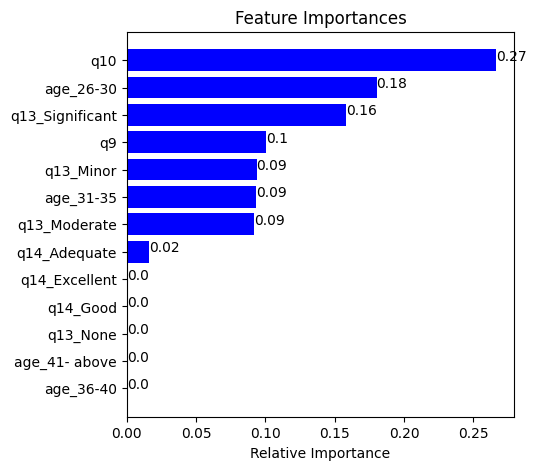

In [ ]:
# Understanding Feature Importance
bestDT_importance = best_dt_classifier.feature_importances_
bestDT_index = np.argsort(bestDT_importance)

plt. figure(figsize=(5, 5))
plt.title('Feature Importances')
plt.barh(range(len(bestDT_index)), bestDT_importance[bestDT_index], color='b', align='center')
plt.yticks(range(len(bestDT_index)), [x_test_DT.columns[i] for i in bestDT_index])
plt.xlabel('Relative Importance')

for i in range(len(bestDT_importance)):
  plt.text(bestDT_importance[bestDT_index[i]],i,round(bestDT_importance[bestDT_index[i]],2))

plt.show()

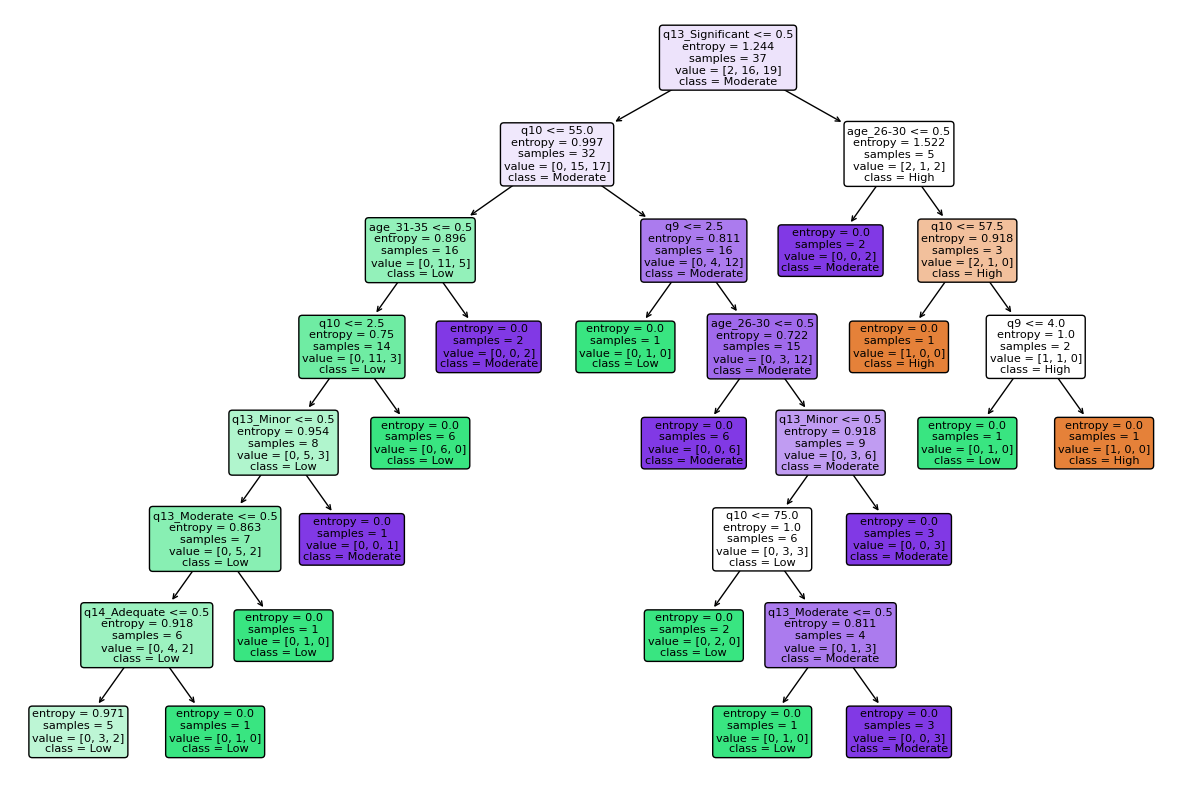

In [ ]:
# Plot and display the pruned decision tree diagram
plt.figure(figsize=(15, 10))
plot_tree(best_dt_classifier, feature_names=DT_x.columns, class_names=best_dt_classifier.classes_, filled=True, rounded=True)
plt.show()

### **K-Nearest Neighbor Classifier**
* (q1) Target Attribute: Level of Digital Health Adoption (Low, Moderate, and High)
* Other Attributes: (q7) Frequency of Telehealth Consultations, (q8) Time Spent on Health Applications (in hrs.), (q9) Trust in Telehealth (scale 1-5), and (q10) Digital Health Literacy Score (score 0-100)

###### **Default K-Nearest Neighbor Classifier**
(Scaled and Unscaled X values)

In [ ]:
# Separate features and target variable
KNN_x = pd.get_dummies(df[["q7","q8","q9","q10"]])
le = LabelEncoder()
KNN_y = le.fit_transform(df['q1'])

# Split the dataset into a training set and a testing set
x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN = train_test_split(KNN_x, KNN_y, train_size= 0.7, test_size=0.3, random_state=42)

# Since KNN is a distance-based algorithms it is affected by the range of features.
# Hence, we need to scale. For this assignment however, we want to show both scaled
# and unscaled performance of the model.
sc = StandardScaler()
sc.fit(x_train_KNN)

X_train_std = sc.transform(x_train_KNN)
X_test_std = sc.transform(x_test_KNN)

# Initialize the K-Nearest Neighbors (KNN) Classifier
k = round(math.sqrt(len(KNN_x)))  # The optimal K value usually follows this formula.
KNN_clf = KNeighborsClassifier(n_neighbors=k)
KNN_clf_standard = KNeighborsClassifier(n_neighbors=k)

# Fit the classifier to the training data
KNN_clf.fit(x_train_KNN, y_train_KNN)            # Not Standardized
KNN_clf_standard.fit(X_train_std, y_train_KNN)   # Standardized

# Make predictions on the test data
y_pred_KNN = KNN_clf.predict(x_test_KNN)                           # Not Standardized
y_pred_KNN_Standard = KNN_clf_standard.predict(X_test_std)         # Standardized

# Calculate the accuracy of the classifier
KNN_accuracy = accuracy_score(y_test_KNN, y_pred_KNN)
KNN_accuracy_standard = accuracy_score(y_test_KNN, y_pred_KNN_Standard)

print("WITHOUT Feature Scaling")
print(f"Accuracy on training set: {KNN_clf.score(x_train_KNN, y_train_KNN) * 100:.2f}%")
print(f"Accuracy on test set: {KNN_accuracy * 100:.2f}%")

print("\nWITH Feature Scaling")
print(f"Accuracy on training set: {KNN_clf_standard.score(X_train_std, y_train_KNN) * 100:.2f}%")
print(f"Accuracy on test set: {KNN_accuracy_standard  * 100:.2f}%")

WITHOUT Feature Scaling
Accuracy on training set: 70.27%
Accuracy on test set: 52.94%

WITH Feature Scaling
Accuracy on training set: 70.27%
Accuracy on test set: 58.82%


In [ ]:
KNN_clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 7,
 'p': 2,
 'weights': 'uniform'}

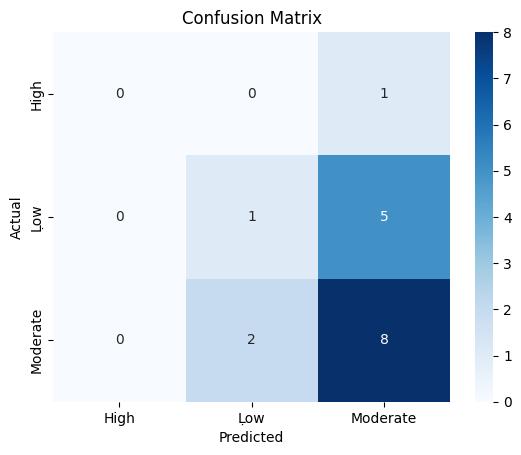


Classification Report:
               precision    recall  f1-score   support

        High     0.0000    0.0000    0.0000         1
         Ḷow     0.3333    0.1667    0.2222         6
    Moderate     0.5714    0.8000    0.6667        10

    accuracy                         0.5294        17
   macro avg     0.3016    0.3222    0.2963        17
weighted avg     0.4538    0.5294    0.4706        17



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Unscaled model
# Display the confusion matrix
KNN_conf_matrix = confusion_matrix(y_test_KNN, y_pred_KNN)
sns.heatmap(KNN_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["High", "Ḷow","Moderate"], yticklabels=["High", "Ḷow","Moderate"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report with precision, recall, and F1-score
KNN_report = classification_report(y_test_KNN, y_pred_KNN, digits = 4, target_names=["High", "Ḷow","Moderate"])
print("\nClassification Report:\n", KNN_report)

The warning on top of the code is due to the fact that there is no F-score to calculate for the "0" label or "High", and thus the F-score for this case is considered to be 0.0. Since an average of the score was requested, a score of 0 was taken into account.

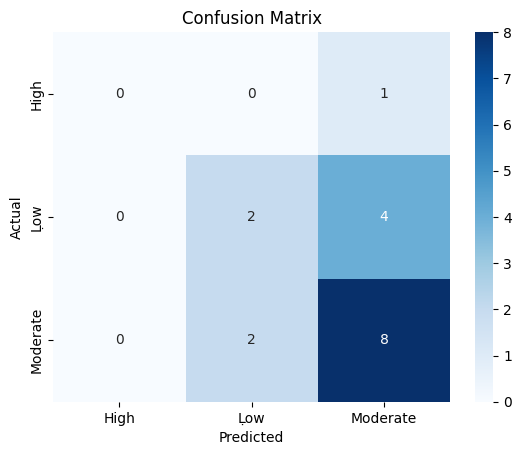


Classification Report:
               precision    recall  f1-score   support

        High     0.0000    0.0000    0.0000         1
         Ḷow     0.5000    0.3333    0.4000         6
    Moderate     0.6154    0.8000    0.6957        10

    accuracy                         0.5882        17
   macro avg     0.3718    0.3778    0.3652        17
weighted avg     0.5385    0.5882    0.5504        17



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Scaled model
# Display the confusion matrix
KNN_conf_matrix_standard = confusion_matrix(y_test_KNN, y_pred_KNN_Standard)
sns.heatmap(KNN_conf_matrix_standard, annot=True, fmt='d', cmap='Blues', xticklabels=["High", "Ḷow","Moderate"], yticklabels=["High", "Ḷow","Moderate"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report with precision, recall, and F1-score
KNN_report_standard = classification_report(y_test_KNN, y_pred_KNN_Standard, digits = 4, target_names=["High", "Ḷow","Moderate"])
print("\nClassification Report:\n", KNN_report_standard)

###### **Hyper Parameterized K-Nearest Neighbor Classifier**
(Scaled features)

Parameters

* n_neighbors:
> This hyperparameter represents the number of nearest neighbors used for classification. It specifies how many data points (neighbors) from the training dataset should be considered when making predictions for a new data point.

* weights:
> The weights hyperparameter determines how the neighbors' contributions are weighted when making predictions. There are typically two options:
'uniform': All neighbors have equal weight, regardless of their distance from the target data point.
'distance': Closer neighbors have more influence on the prediction than farther neighbors. It assigns higher weight to neighbors that are closer to the target data point.

* p:
> The p hyperparameter represents the power parameter for the Minkowski distance metric. It's used to calculate the distance between data points. The Minkowski distance can be defined as:
When p = 1, it corresponds to the Manhattan distance (L1 norm).
When p = 2, it corresponds to the Euclidean distance (L2 norm).
Other values of p are also possible, allowing you to use custom distance metrics.

In [ ]:
# Define hyperparameters for tuning
## Parameters are based on the results of Default K-Nearest Neighbor Classifier
KNN_param_grid = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Create a GridSearchCV object for hyperparameter tuning
KNN_grid_search = GridSearchCV(KNN_clf_standard, KNN_param_grid, cv=5)

# Fit the model to the training data
KNN_grid_search.fit(X_train_std, y_train_KNN)

# Make predictions on the test data
y_pred_best_KNN = KNN_grid_search.predict(X_test_std)

# Get the best hyperparameters
KNN_best_params = KNN_grid_search.best_params_

# Train a decision tree with the best hyperparameters
best_KNN_classifier = KNeighborsClassifier(**KNN_best_params)
best_KNN_classifier.fit(X_train_std, y_train_KNN)

# Evaluate the model on the test data
accuracy_bestKNN = best_KNN_classifier.score(X_test_std, y_test_KNN)
print(f"Accuracy on training set: {best_KNN_classifier.score(X_train_std, y_train_KNN) * 100:.2f}%")
print(f"Accuracy on test set: {accuracy_bestKNN* 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Accuracy on training set: 70.27%
Accuracy on test set: 64.71%


In [ ]:
#Show best parameters
KNN_best_params

{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}

In [ ]:
# Access the results
KNN_results = KNN_grid_search.cv_results_

# Print all the results
i = 0
for mean_score, params in zip(KNN_results["mean_test_score"], KNN_results["params"]):
    i = i + 1
    print(f"{i}. Mean Test Score: {mean_score:.4f}, Hyperparameters: {params}")

1. Mean Test Score: 0.5750, Hyperparameters: {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
2. Mean Test Score: 0.5750, Hyperparameters: {'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
3. Mean Test Score: 0.5464, Hyperparameters: {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
4. Mean Test Score: 0.5464, Hyperparameters: {'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
5. Mean Test Score: 0.5429, Hyperparameters: {'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
6. Mean Test Score: 0.5464, Hyperparameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
7. Mean Test Score: 0.5429, Hyperparameters: {'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
8. Mean Test Score: 0.5179, Hyperparameters: {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
9. Mean Test Score: 0.4893, Hyperparameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
10. Mean Test Score: 0.4893, Hyperparameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
11. Mean Test Score: 0.5179, Hyperparameters: {'n_neig

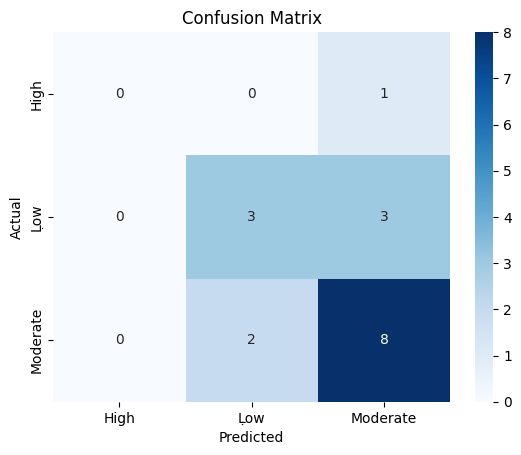


Classification Report:
               precision    recall  f1-score   support

        High     0.0000    0.0000    0.0000         1
         Ḷow     0.6000    0.5000    0.5455         6
    Moderate     0.6667    0.8000    0.7273        10

    accuracy                         0.6471        17
   macro avg     0.4222    0.4333    0.4242        17
weighted avg     0.6039    0.6471    0.6203        17



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Display the confusion matrix
bestKNN_conf_matrix = confusion_matrix(y_test_KNN, y_pred_best_KNN)
sns.heatmap(bestKNN_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["High", "Ḷow","Moderate"], yticklabels=["High", "Ḷow","Moderate"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report with precision, recall, and F1-score
bestKNN_report = classification_report(y_test_KNN, y_pred_best_KNN, digits = 4, target_names=["High", "Ḷow","Moderate"])
print("\nClassification Report:\n", bestKNN_report)

###### **K-Nearest Neighbor Classifier with PCA**
(Scaled features)

In [ ]:
# Since the data is multi-attribute / multi-class we need to decompose this
# such that it can be plotted in a 2D plane.
from sklearn.decomposition import PCA

# Apply PCA to reduce the dimensionality
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Retrain the KNN model using the reduced-dimensional feature space:
knn_pca = KNeighborsClassifier(n_neighbors=k)
knn_pca.fit(X_train_pca, y_train_KNN)

# Make predictions on the test data
y_pred_KNN_pca = knn_pca.predict(X_test_pca)

# Evaluate on the retrained model
# Calculate the accuracy of the classifier
KNN_pca_accuracy = accuracy_score(y_test_KNN, y_pred_KNN_pca )
print("Model Evaluation on the Retrained Model\n")
print(f"Accuracy on training set: {knn_pca.score(X_train_pca, y_train_KNN) * 100:.2f}%")
print(f"Accuracy on test set: {KNN_pca_accuracy * 100:.2f}%")

Model Evaluation on the Retrained Model

Accuracy on training set: 70.27%
Accuracy on test set: 52.94%


###### **Hyper Parameterized K-Nearest Neighbor Classifier with PCA**
(Scaled features)

In [ ]:
KNN_pca_grid_search = GridSearchCV(knn_pca, KNN_param_grid, cv=5)
KNN_pca_grid_search.fit(X_train_pca, y_train_KNN)

y_pred_best_KNN_pca = KNN_pca_grid_search.predict(X_test_pca)
KNN_pca_best_params = KNN_pca_grid_search.best_params_

best_KNN_pca_classifier = KNeighborsClassifier(**KNN_pca_best_params)
best_KNN_pca_classifier.fit(X_train_pca, y_train_KNN)

accuracy_bestKNN_pca = best_KNN_pca_classifier.score(X_test_pca, y_test_KNN)
print(f"Accuracy on training set: {best_KNN_pca_classifier.score(X_train_pca, y_train_KNN) * 100:.2f}%")
print(f"Accuracy on test set: {accuracy_bestKNN_pca* 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Accuracy on training set: 100.00%
Accuracy on test set: 52.94%


### **Naive-Bayes Classifier**

* (q1) Target Attribute: Level of Digital Health Adoption (Low, Moderate, and High)
* Other Attributes: (age) Age Range, (q9) Trust in Telehealth (scale 1-5), (q10) Digital Health Literacy Score (score 0-100), (q13) Self-Reported Health Improvement due to Digital Health (None, Minor, Moderate, Significant), and (q14) Accessibility of Telehealth Services (Limited, Adequate, Good, Excellent)

###### **Default Naive Bayes Classifier**

In [ ]:
# Separate features and target variable
NB_x = pd.get_dummies(df[["age","q9","q10","q13","q14"]],drop_first=True) # Apply one-hot encoding for the categorical column
NB_y = df['q1']

# Split the dataset into a training set and a testing set
x_train_NB, x_test_NB, y_train_NB, y_test_NB = train_test_split(NB_x, NB_y, train_size= 0.7, test_size=0.3, random_state=42)

# Initialize the Naive Bayes Classifier
NB_clf = GaussianNB()

# Fit the classifier to the training data
NB_clf.fit(x_train_NB, y_train_NB)

# Make predictions on the test data
y_pred_NB = NB_clf.predict(x_test_NB)

# Calculate the accuracy of the classifier
NB_accuracy = accuracy_score(y_test_NB, y_pred_NB)
print(f"Accuracy on training set: {NB_clf.score(x_train_NB, y_train_NB) * 100:.2f}%")
print(f"Accuracy on test set: {NB_accuracy * 100:.2f}%")

Accuracy on training set: 56.76%
Accuracy on test set: 41.18%


Possible reasons why accuracy is high

* Small training/test dataset
* Presence of too many independent variables
* Conditional probabilities engulf one above the other
* High correlation between independent variables

Reasons for using Multinomial Naive Bayes over Gaussian Naive Bayes
* Categorical data (real-valued data)
* Most of the data are discrete and in terms of counts (VS continuous)
* The distribution is multinomial (VS Gaussian/Normal)

In [ ]:
NB_clf.get_params()

{'priors': None, 'var_smoothing': 1e-09}

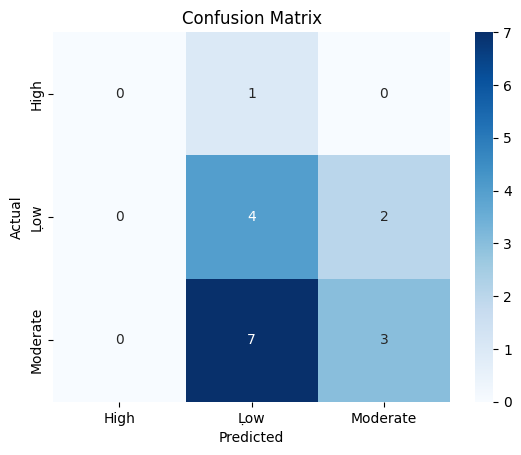


Classification Report:
               precision    recall  f1-score   support

        High     0.0000    0.0000    0.0000         1
         Low     0.3333    0.6667    0.4444         6
    Moderate     0.6000    0.3000    0.4000        10

    accuracy                         0.4118        17
   macro avg     0.3111    0.3222    0.2815        17
weighted avg     0.4706    0.4118    0.3922        17



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Display the confusion matrix
NB_conf_matrix = confusion_matrix(y_test_NB, y_pred_NB)
sns.heatmap(NB_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["High", "Ḷow","Moderate"], yticklabels=["High", "Ḷow","Moderate"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report with precision, recall, and F1-score
NB_report = classification_report(y_test_NB, y_pred_NB, digits = 4)
print("\nClassification Report:\n", NB_report)

###### **Hyper Parameterized Naive Bayes Classifier**

Parameters

* alpha:
> The alpha parameter controls the Laplace smoothing (additive smoothing) applied to the likelihood probabilities in the Naive Bayes classifier.

In [ ]:
# Define hyperparameters for tuning (typically alpha)
NB_param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}

# Create a GridSearchCV object for hyperparameter tuning
NB_grid_search = GridSearchCV(NB_clf, NB_param_grid, cv=5)

# Fit the model to the training data
NB_grid_search.fit(x_train_NB, y_train_NB)

# Make predictions on the test data
y_pred_best_NB = NB_grid_search.predict(x_test_NB)

# Get the best hyperparameters
NB_best_params = NB_grid_search.best_params_

# Train a decision tree with the best hyperparameters
best_NB_classifier = GaussianNB(**NB_best_params)
best_NB_classifier.fit(x_train_NB, y_train_NB)

# Evaluate the model on the test data
accuracy_bestNB = best_NB_classifier.score(x_test_NB, y_test_NB)
print(f"Accuracy on training set: {best_NB_classifier.score(x_train_NB, y_train_NB) * 100:.2f}%")
print(f"Accuracy on test set: {accuracy_bestNB* 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Accuracy on training set: 64.86%
Accuracy on test set: 64.71%


In [ ]:
#Show best parameters
NB_best_params

{'var_smoothing': 0.001}

In [ ]:
# Access the results
NB_results = NB_grid_search.cv_results_

# Print all the results
i = 0
for mean_score, params in zip(NB_results["mean_test_score"], NB_results["params"]):
    i = i + 1
    print(f"{i}. Mean Test Score: {mean_score:.4f}, Hyperparameters: {params}")

1. Mean Test Score: 0.3750, Hyperparameters: {'var_smoothing': 1e-09}
2. Mean Test Score: 0.3750, Hyperparameters: {'var_smoothing': 1e-08}
3. Mean Test Score: 0.3750, Hyperparameters: {'var_smoothing': 1e-07}
4. Mean Test Score: 0.4000, Hyperparameters: {'var_smoothing': 1e-06}
5. Mean Test Score: 0.5107, Hyperparameters: {'var_smoothing': 1e-05}
6. Mean Test Score: 0.5714, Hyperparameters: {'var_smoothing': 0.0001}
7. Mean Test Score: 0.6071, Hyperparameters: {'var_smoothing': 0.001}
8. Mean Test Score: 0.6036, Hyperparameters: {'var_smoothing': 0.01}
9. Mean Test Score: 0.6036, Hyperparameters: {'var_smoothing': 0.1}


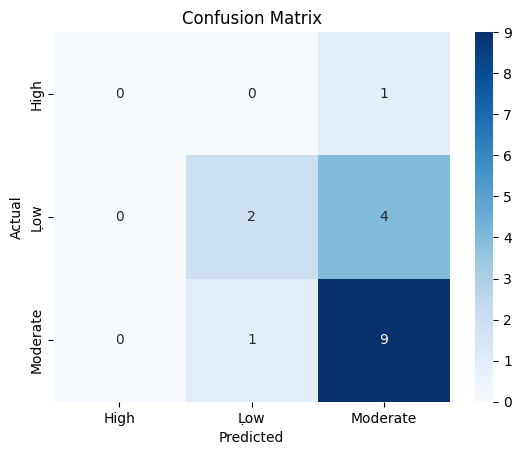


Classification Report:
               precision    recall  f1-score   support

        High     0.0000    0.0000    0.0000         1
         Low     0.6667    0.3333    0.4444         6
    Moderate     0.6429    0.9000    0.7500        10

    accuracy                         0.6471        17
   macro avg     0.4365    0.4111    0.3981        17
weighted avg     0.6134    0.6471    0.5980        17



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Display the confusion matrix
bestNB_conf_matrix = confusion_matrix(y_test_NB, y_pred_best_NB )
sns.heatmap(bestNB_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["High", "Ḷow","Moderate"], yticklabels=["High", "Ḷow","Moderate"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report with precision, recall, and F1-score
bestNB_report = classification_report(y_test_NB, y_pred_best_NB , digits = 4)
print("\nClassification Report:\n", bestNB_report)

## **Model Comparison and Validation**

### **Classifier Comparison and Cross Validation**

In [ ]:
# Initialize cross-validation parameters
cv = 5                                                                                     # Standard k-folds
kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)                               # Stratified
shuffle_split = ShuffleSplit(test_size=.3, train_size=.7, n_splits=5, random_state = 42)   # Shuffle

In [ ]:
#Standard Cross Validation
stan_score1 = cross_val_score(best_dt_classifier, DT_x, DT_y, cv=cv)
stan_score2 = cross_val_score(best_KNN_classifier, sc.transform(KNN_x), KNN_y, cv=cv)
stan_score3 = cross_val_score(best_NB_classifier, NB_x, NB_y, cv=cv)

print("STANDARD CROSS VALIDATION\n")
print("Scores (DT): {}".format(stan_score1))
print("Scores (KNN): {}".format(stan_score2))
print("Scores (NB): {}".format(stan_score3))
print("\n")
print("Average score (DT): {:.2f}".format(stan_score1.mean()))
print("Average score (KNN): {:.2f}".format(stan_score2.mean()))
print("Average score (NB): {:.2f}".format(stan_score3.mean()))

STANDARD CROSS VALIDATION

Scores (DT): [0.54545455 0.45454545 0.54545455 0.54545455 0.4       ]
Scores (KNN): [0.81818182 0.63636364 0.63636364 0.27272727 0.7       ]
Scores (NB): [0.72727273 0.54545455 0.54545455 0.45454545 0.4       ]


Average score (DT): 0.50
Average score (KNN): 0.61
Average score (NB): 0.53


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
#Stratified Cross Validation
strat_score1 = cross_val_score(best_dt_classifier, DT_x, DT_y, cv=kfold)
strat_score2 = cross_val_score(best_KNN_classifier, sc.transform(KNN_x), KNN_y, cv=kfold)
strat_score3 = cross_val_score(best_NB_classifier, NB_x, NB_y, cv=kfold)

print("STRATIFIED CROSS VALIDATION\n")
print("Scores (DT): {}".format(strat_score1))
print("Scores (KNN): {}".format(strat_score2))
print("Scores (NB): {}".format(strat_score3))
print("\n")
print("Average score (DT): {:.2f}".format(strat_score1.mean()))
print("Average score (KNN): {:.2f}".format(strat_score2.mean()))
print("Average score (NB): {:.2f}".format(strat_score3.mean()))

STRATIFIED CROSS VALIDATION

Scores (DT): [0.36363636 0.54545455 0.54545455 0.63636364 0.2       ]
Scores (KNN): [0.81818182 0.45454545 0.72727273 0.54545455 0.7       ]
Scores (NB): [0.81818182 0.36363636 0.63636364 0.72727273 0.5       ]


Average score (DT): 0.46
Average score (KNN): 0.65
Average score (NB): 0.61


In [ ]:
#Shuffle-split Cross Validation
shuffle_score1 = cross_val_score(best_dt_classifier, DT_x, DT_y, cv=shuffle_split)
shuffle_score2 = cross_val_score(best_KNN_classifier, sc.transform(KNN_x), KNN_y, cv=shuffle_split)
shuffle_score3 = cross_val_score(best_NB_classifier, NB_x, NB_y, cv=shuffle_split)

print("Shuffle-split CROSS VALIDATION\n")
print("Scores (DT): {}".format(shuffle_score1))
print("Scores (KNN): {}".format(shuffle_score2))
print("Scores (NB): {}".format(shuffle_score3))
print("\n")
print("Average score (DT): {:.2f}".format(shuffle_score1.mean()))
print("Average score (KNN): {:.2f}".format(shuffle_score2.mean()))
print("Average score (NB): {:.2f}".format(shuffle_score3.mean()))

Shuffle-split CROSS VALIDATION

Scores (DT): [0.47058824 0.41176471 0.35294118 0.64705882 0.64705882]
Scores (KNN): [0.64705882 0.58823529 0.41176471 0.58823529 0.70588235]
Scores (NB): [0.64705882 0.47058824 0.35294118 0.64705882 0.70588235]


Average score (DT): 0.51
Average score (KNN): 0.59
Average score (NB): 0.56


### **Others: Randomly testing the models developed**

In [ ]:
#Sample use of the model

# Initialize data to lists.
data1 = [{x_test_DT.columns[0]: 5,
         x_test_DT.columns[1]: 2.0,
         x_test_DT.columns[2]: 1,
         x_test_DT.columns[3]: 5,
         x_test_DT.columns[4]: 1,
         x_test_DT.columns[5]: 1,
         x_test_DT.columns[6]: 0,
         x_test_DT.columns[7]: 1,
          x_test_DT.columns[8]: 1,
          x_test_DT.columns[9]: 1,
          x_test_DT.columns[10]: 1,
          x_test_DT.columns[11]: 1,
          x_test_DT.columns[12]: 1
         }]

data2 = [{x_test_KNN.columns[0]: 5,
         x_test_KNN.columns[1]: 2.0,
         x_test_KNN.columns[2]: 1,
         x_test_KNN.columns[3]: 5
         }]

data3 = [{x_test_NB.columns[0]: 5,
         x_test_NB.columns[1]: 2.0,
         x_test_NB.columns[2]: 1,
         x_test_NB.columns[3]: 5,
         x_test_NB.columns[4]: 1,
         x_test_NB.columns[5]: 1,
         x_test_NB.columns[6]: 0,
         x_test_NB.columns[7]: 1,
         x_test_NB.columns[8]: 0,
         x_test_NB.columns[9]: 0,
         x_test_NB.columns[10]: 0,
         x_test_NB.columns[11]: 0,
         x_test_NB.columns[12]: 0,
         }]

# Creates DataFrame.
sample1 = pd.DataFrame(data1)
sample2 = pd.DataFrame(data2)
sample3 = pd.DataFrame(data3)

# Predict sample data
print(f"Decision Tree: {best_dt_classifier.predict(sample1)} \nK-Nearest Neightbor: {KNN_clf.predict(sc.transform(sample2))} \nNaive Bayes: {best_NB_classifier.predict(sample3)}")

Decision Tree: ['High'] 
K-Nearest Neightbor: [2] 
Naive Bayes: ['Moderate']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [ ]:
len(x_test_NB.columns)

13

In [ ]:
# Separate features and target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['q1'])
DT_y = le.transform(df['q1'])
DT_y

array([2, 1, 0, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 0, 2, 2, 1, 1, 2,
       1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 0, 2, 2, 2, 2])

## **Examples of KNN Visualization**

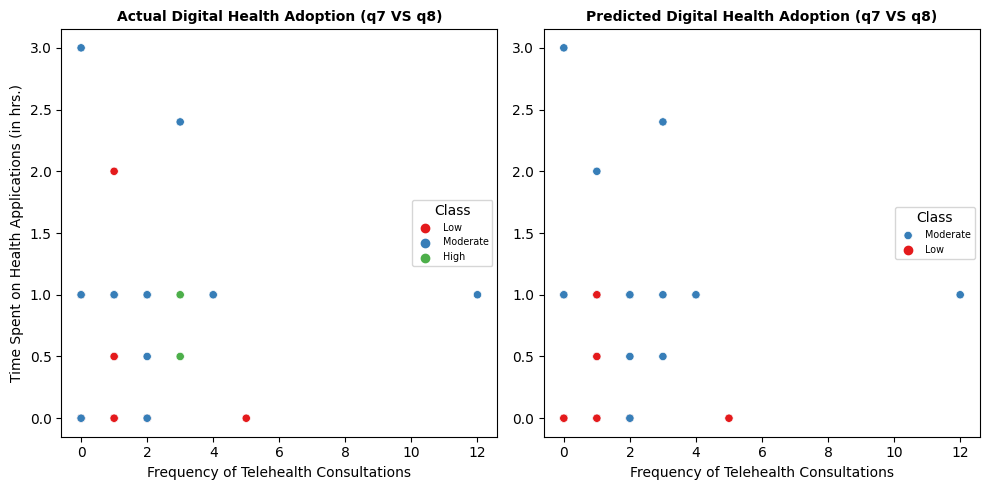

In [ ]:
# Example Plot No. 1: (q7)Frequency of Telehealth Consultations VS (q8) Time Spent on Health Applications (in hrs.)
# Create a larger figure for the scatterplot
plt.figure(figsize=(10, 5))

# Plot 1 (Actual - Left)
plt.subplot(1, 2, 1)
q78scatterplot_actual = sns.scatterplot(x = df['q7'], y = df['q8'],
                                        hue = df['q1'], legend = 'brief', palette='Set1')
plt.title('Actual Digital Health Adoption (q7 VS q8)', fontsize = 10, fontweight='bold')
plt.xlabel('Frequency of Telehealth Consultations')
plt.ylabel('Time Spent on Health Applications (in hrs.)')
q78scatterplot_actual.legend(title='Class', loc='center right', fontsize='x-small')

# Plot 2 (Predicted - Right)
plt.subplot(1, 2, 2)
q78scatterplot_predicted = sns.scatterplot(x = df['q7'], y = df['q8'], hue = best_KNN_classifier.predict(sc.transform(KNN_x)),
                                           legend='brief', palette='Set1')
plt.title('Predicted Digital Health Adoption (q7 VS q8)', fontsize = 10, fontweight='bold')
plt.xlabel('Frequency of Telehealth Consultations')
plt.ylabel('')
q78scatterplot_predicted.legend(title='Class', loc='center right', fontsize='x-small', labels=['Moderate', 'Low'])

# Show the plot
plt.tight_layout()
plt.show()

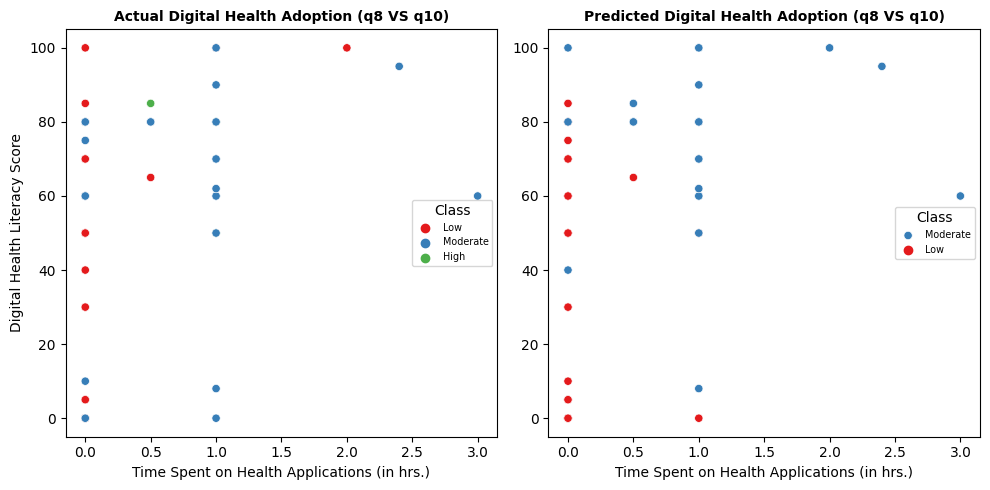

In [ ]:
# Example Plot No. 2: (q8) Time Spent on Health Applications (in hrs.) VS (q10) Digital Health Literacy Score (score 0-100)
# Create a larger figure for the scatterplot
plt.figure(figsize=(10, 5))

# Plot 1 (Actual - Left)
plt.subplot(1, 2, 1)
q810scatterplot_actual = sns.scatterplot(x = df['q8'], y = df['q10'],
                                        hue = df['q1'], legend = 'brief', palette='Set1')
plt.title('Actual Digital Health Adoption (q8 VS q10)', fontsize = 10, fontweight='bold')
plt.xlabel('Time Spent on Health Applications (in hrs.)')
plt.ylabel('Digital Health Literacy Score')
q810scatterplot_actual.legend(title='Class', loc='center right', fontsize='x-small')

# Plot 2 (Predicted - Right)
plt.subplot(1, 2, 2)
q810scatterplot_predicted = sns.scatterplot(x = df['q8'], y = df['q10'], hue = best_KNN_classifier.predict(sc.transform(KNN_x)),
                                           legend='brief', palette='Set1')
plt.title('Predicted Digital Health Adoption (q8 VS q10)', fontsize = 10, fontweight='bold')
plt.xlabel('Time Spent on Health Applications (in hrs.)')
plt.ylabel('')
q810scatterplot_predicted.legend(title='Class', loc='center right', fontsize='x-small', labels=['Moderate', 'Low'])

# Show the plot
plt.tight_layout()
plt.show()

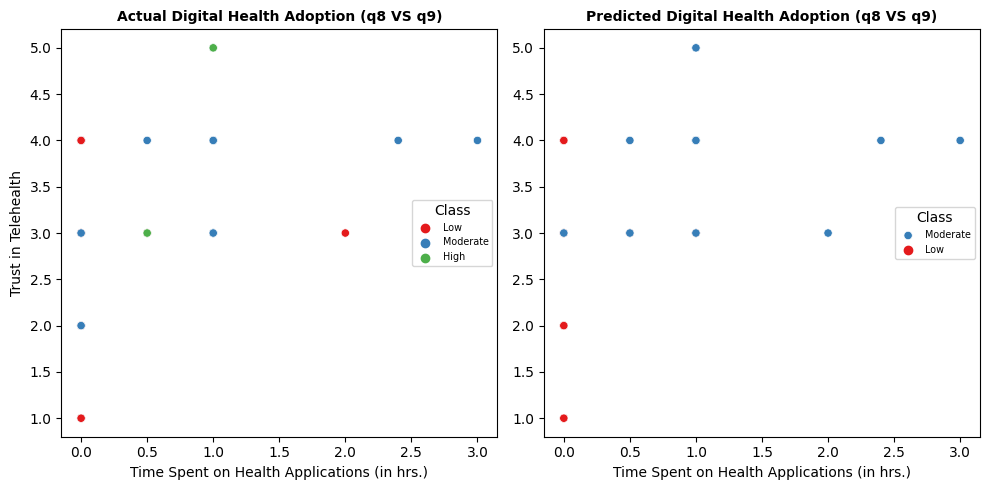

In [ ]:
# Example Plot No. 3: (q8) Time Spent on Health Applications (in hrs.) VS (q9) Trust in Telehealth (scale 1-5)
# Create a larger figure for the scatterplot
plt.figure(figsize=(10, 5))

# Plot 1 (Actual - Left)
plt.subplot(1, 2, 1)
q89scatterplot_actual = sns.scatterplot(x = df['q8'], y = df['q9'],
                                        hue = df['q1'], legend = 'brief', palette='Set1')
plt.title('Actual Digital Health Adoption (q8 VS q9)', fontsize = 10, fontweight='bold')
plt.xlabel('Time Spent on Health Applications (in hrs.)')
plt.ylabel('Trust in Telehealth')
q89scatterplot_actual.legend(title='Class', loc='center right', fontsize='x-small')

# Plot 2 (Predicted - Right)
plt.subplot(1, 2, 2)
q89scatterplot_predicted = sns.scatterplot(x = df['q8'], y = df['q9'], hue = best_KNN_classifier.predict(sc.transform(KNN_x)),
                                           legend='brief', palette='Set1')
plt.title('Predicted Digital Health Adoption (q8 VS q9)', fontsize = 10, fontweight='bold')
plt.xlabel('Time Spent on Health Applications (in hrs.)')
plt.ylabel('')
q89scatterplot_predicted.legend(title='Class', loc='center right', fontsize='x-small', labels=['Moderate', 'Low'])

# Show the plot
plt.tight_layout()
plt.show()

## **Manual Naive-Bayes Computation**

In [ ]:
# Data
NB_df = df[["q1","age","q9","q10","q13","q14"]]

# Get frequncy per class in NB_df dataset
NB_C = NB_df.groupby(['q1']).size()

# Get frequncy per attribute given class in NB_df dataset
NB_age = NB_df[NB_df.age == "26-30"].groupby(['q1']).size()
NB_q9 = NB_df[NB_df.q9 == 5].groupby(['q1']).size()
NB_q10 = NB_df[NB_df.q10 == 80].groupby(['q1']).size()
NB_q13 = NB_df[NB_df.q13 == "Moderate"].groupby(['q1']).size()
NB_q14 = NB_df[NB_df.q14 == "Adequate"].groupby(['q1']).size()

# Solve for the P(X | Low)
px_given_low = (NB_age[0] / NB_C[0]) * (NB_q9[0] / NB_C[0]) * (NB_q10[0] / NB_C[0]) * (NB_q13[0] / NB_C[0])* (NB_q14[0] / NB_C[0])
px_given_moderate = (NB_age[1] / NB_C[1]) * (NB_q9[1] / NB_C[1]) * (NB_q10[1] / NB_C[1]) * (NB_q13[1] / NB_C[1])* (NB_q14[1] / NB_C[1])
px_given_high = (NB_age[2] / NB_C[2]) * (NB_q9[2] / NB_C[2]) * (NB_q10[2] / NB_C[2]) * (NB_q13[2] / NB_C[2])* (NB_q14[2] / NB_C[2])

# Solve for the P(X | Low) * P(q1 = Low)
LOW = px_given_low * (NB_C[0]/len(NB_df))

# Solve for the P(X | Low) * P(q1 = Moderate)
MODERATE = px_given_moderate * (NB_C[1]/len(NB_df))

# Solve for the P(X | Low) * P(q1 = High)
HIGH = px_given_high * (NB_C[2]/len(NB_df))

print(f'Low Class: {LOW} | Moderate Class: {MODERATE} | High Class: {HIGH}')

Low Class: 0.0 | Moderate Class: 0.00047788644117401714 | High Class: 0.0
